# Convolutional Neural Networks

Recall that in previous notebooks to classify images we flattened them into long vectors as inputs to MLPs. This is unstatisfying since we are discarding important spatial information, i.e. observe that MLPs are invariant to a permutation of the neurons. In addition to this, a dense layer taking in a 256 x 256 RGB image producing a 256 x 256 x 3 image of the same dimensions would require around 39 billion parameters. This requires too much memory and results in excess capacity for a single layer.

It would be nice if we can include our prior knowledge that pixels are spatially related in some way into the structure of our networks. For tasks such as object detection and classification, we can abstract away two desirable properties: **translation invariance** and **locality**. For our purposes, we take "translation invariance" to mean that a transformation that is meaningful at a certain location should be also meaningful everywhere. In addition, we want the transformation to be local because since discriminative features for images typically exist only on localized regions, e.g. a dog's nose or cat ears, and looking at large regions of the image can potentially confuse the network.

In [1]:
import tensorflow as tf
from tensorflow import keras as kr
import numpy as np
import matplotlib.pyplot as plt

from inefficient_networks import utils
from inefficient_networks.config import config

config.set_tensorflow_seeds(0)
config.set_matplotlib("png")
print(tf.__version__)

2.8.0


## Convolution operation

In this section, we look at **convolution** which embody this idea of capturing local effects with a transformation that is somewhat translationally invariant. Convolution for a kernel $\mathbf K$ and an input image $\mathbf X$ is defined as

$$
(\mathbf X \circledast \mathbf K)_{ij} = \sum_{h = 1}^{k_1} \sum_{w=1}^{k_2} {\mathbf K}_{hw}\, {\mathbf X}_{i + h, j + w}.
$$

Observe that the kernel $\mathbf K$ is applied locally on a patch of size $k_1 \times k_2.$ The figure below show two convolution operations for 1-dimensional signals. Note that depending on the kernel, convolutions can be used to capture patterns (top), and also as differential operators (bottom). The latter can be useful for detecting features such as edges.


```{margin}
[[source]](https://fleuret.org/dlc/materials/dlc-handout-4-4-convolutions.pdf)
```
```{figure} ../../img/conv-effect.png
---
width: 40em
---
Convolution for 1-dimensional signals.
```



For neural networks, a **convolutional layer** replaces the dense operation with a convolution between the input tensor $\mathbf X$ and the weights $\mathbf W$ so that it implements the computation $\mathbf H = \varphi( u + \mathbf X \circledast \mathbf W)$ for a nonlinear activation $\varphi.$  This significantly reduces the size of the weight matrix. Since images have channels, we extend the 2-dimensional convolution layer to having an extra dimension indexed by $c_\text{out}$:

$$
\begin{aligned}
{\mathbf H}_{ij,\, c_\text{out}} 
&= \varphi\left(u_{c_\text{out}} + \sum_{h = 0}^{k_1-1} \sum_{w=0}^{k_2-1} {\mathbf K}_{hw,\,{c_\text{in}},\,{c_\text{out}}} \, {\mathbf X}_{i + h,\, j + w,\, c_\text{in}} \right)
\end{aligned}
$$

Here the first two indices for navigating along the spatial dimensions of the input image. This is done for each input channel, so we require a third dimension indexed by $c_{in}.$
Finally, we have such 3-dimensional tensors for each output channel, so that our final weight tensor is a 4-dimensional tensor. We can think of this geometrically as having $c_\text{out}$ filters of shape $(k_1, k_2, c_\text{in})$ which forms a $(k_1, k_2, c_\text{in}, c_\text{out})$ weight tensor. Note that if the input image $\mathbf X$ has spatial dimensions $H \times W$, then the resulting image $\mathbf H$ has spatial dimension $(H - h + 1) \times (W - w +1).$

<br>

```{margin}
[[Krizhevsky et. al.]](https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html)
```

```{figure} ../../img/kernels_cnn.jpeg
---

---
Kernels learned by the first layer of AlexNet. Each of the 96 kernels shown here is of size 11x11x3,  shared by the 55x55 neurons in each of the 96 output channels. Note that most of these look like edge detectors.

Consistent with the above equation, TensorFlow expects input images to be of shape `(B, H, W, c)` for an batch input of size `B` of `H x W` images with `c` channels. Note that since these layers will be stacked, this is also expected the shape of output of a convolutional layer.

In [2]:
X = tf.random.normal(shape=(256, 28, 28, 1))             # (B, H_in, W_in, c_in)
conv = kr.layers.Conv2D(filters=3, kernel_size=(5, 5))   # [(5, 5, c_in, c_out), (c_out,)]

# Get out image, and check shapes
Y = conv(X)
K = conv.weights[0]
u = conv.weights[1]

# Check if implementation follows above formula
h, w = 5, 5
B, H, W, c = X.shape
H_out, W_out, c_out = H-h+1, W-w+1, 3
out = np.zeros(shape=(B, H_out, W_out, c_out))
for i in range(out.shape[1]):
    for j in range(out.shape[2]):
        XX = X.numpy()[:, i: i+h, j: j+w, :].reshape(B, -1)
        KK = K.numpy().reshape(h*w, -1)
        out[:, i, j, :] = u + (XX @ KK)

print(Y.shape)   # (B, H_out, W_out, c_out)
print(K.shape)   # (h, w, c_in, c_out)
print(u.shape)   # (c_out,)
print(np.abs(out - conv(X)).mean())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-28 00:37:02.855615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 00:37:02.855751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(256, 24, 24, 3)
(5, 5, 1, 3)
(3,)
0.0


Note that the size of the output is 28 - 5  + 1 = 24. Next, we show that an example showing convolution is a **linear operation**. This can be shown directly from the definition, but here we show an actual construction of convolution as matrix multiplication. 

In [3]:
X = tf.convert_to_tensor(
    [[-1., 2.,-3.],
     [ 4.,-5., 6.],
     [-7., 8.,-9.],]
)[None, :, :, None]

K = tf.convert_to_tensor(
    [[-1.,  1.],
     [ 2., -2.]]
)[:, :, None, None]

conv_small = kr.layers.Conv2D(filters=1, kernel_size=(2, 2))
conv_small.build(input_shape=(256, 3, 3, 1))
conv_small.set_weights([K, tf.zeros(shape=(1,))])


X_ = np.array([-1., 2., -3., 4., -5., 6., -7., 8., -9.,])
K_ = np.array([
    [-1., 0., 0., 0.],
    [ 1.,-1., 0., 0.],
    [ 0., 1., 0., 0.],
    [ 2., 0.,-1., 0.],
    [-2., 2., 1.,-1.],
    [ 0.,-2., 0., 1.],
    [ 0., 0., 2., 0.],
    [ 0., 0.,-2., 2.],
    [ 0., 0., 0.,-2],
])

print((X_ @ K_).reshape(2, 2))
print()
print(tf.reshape(conv_small(X), (2, 2)).numpy())

[[ 21. -27.]
 [-39.  45.]]

[[ 21. -27.]
 [-39.  45.]]


### Stride and padding

The above definition of convolution can be modified to include a parameter $s$ called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $s$ computes:

$$
\begin{aligned}
{\mathbf H}_{ij,\, c_\text{out}} 
&= \varphi\left(u_{c_\text{out}} + \sum_{h = 0}^{k_1-1} \sum_{w=0}^{k_2-1} {\mathbf K}_{hw,\,{c_\text{in}},\,{c_\text{out}}} \, {\mathbf X}_{si + h,\, sj + w,\, c_\text{in}} \right).
\end{aligned}
$$

This includes the original definition which has a step size of 1. Note that strided convolutions can be thought of as a form of downsampling (discussed below) since it results in a significant reduction in image size. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. For example, AlexNet {cite}`imagenet-paper` used a kernel of size 11 x 11 with a stride of 4 in the first layer since objects in the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description) tend to occupy more pixels. 

```{figure} ../../img/imagenet.jpeg
---
width: 45em
name: imagenet
---
Sample images from the ImageNet dataset. {cite}`imagenet`

```

**Padding.** Observe that in the above definition of convolution, the kernel placed entirely within the input image. This has the disadvantage of being biased towards the center pixels, resulting in information loss on the edges of the input image. Also notice that applying convolutions will always result in decreasing spatial dimension which limits the depth of the network. A simple fix is to simply pad the edges with zero, which gives us more space to place the kernel over the edges of the image.


```{margin}
[[source]](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_05.png)
```
```{figure} ../../img/padding.png
---
width: 40em
---
```




<br>

This can implemented in TensorFlow using the `ZeroPadding2D` layer:

(256, 34, 34, 1)


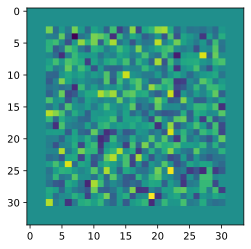

In [4]:
X = tf.random.normal(shape=(256, 28, 28, 1))            
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
plt.imshow(pad(X)[0, :, :, 0]);

### Output size

The spatial dimension of the output is directly influenced by padding `p` and stride `s`. Suppose the layer's input has width `W` and let the kernel have width `f`, then the output image has width `W_out = ⌊(W + 2p - f)/s⌋ + 1` assuming equal padding on both sides. 
Directly using discrete convolution is not always desirable as some pixels of the input are essentially dropped because a kernel cannot be placed within the image to cover them following the set stride:

```bash
input    1 2 3 4 5 6 7 8 9
kernel   0 0 1 0 0       
               0 0 1 0 0
         -----------------                     
output       3     6     
```

For odd kernel size `f` and unit stride `s = 1`, we can use `2p = f - 1` to get same sized outputs and with the kernel covering the entire input in a symmetric manner. For this reason, and also for the sake of symmetry, we [prefer odd-sized kernels](https://datascience.stackexchange.com/a/23186) for convolutions.

```bash
input    0 0 1 2 3 4 5 6 7 8 9 0 0
kernel   0 0 1 0 0
           0 0 1 0 0
                  ...
                       0 0 1 0 0
                         0 0 1 0 0
         -------------------------                        
output       1 2 3 4 5 6 7 8 9
```

For strides `s > 1`, the best practice is to choose a kernel size `f` and the smallest padding `p` such that `s` divides `W + 2p - f`. This way the entire input image is covered symmetrically by the kernel in constructing the convolved image.

```bash
input    0 1 2 3 4 5 6 7 8 9 0
kernel   0 0 1 0 0
               0 0 1 0 0
                     0 0 1 0 0
         ---------------------                         
output       2     5     8
```

**TF implementation.** The `padding` argument in `Conv2D` and other convolutional layers takes in either `"valid"` or `"same"`. The `"valid"` setting means that no padding is used an the kernel is placed only where it can be validly placed within the image. As discussed above this can result in discarding some pixels in the right as well as bottom part of the image. The `"same"` setting is a bit more tricky. Here the image is zero-padded as evenly as possible such that the output image has width `⌈W / s⌉`. Thus, if `⌊(W + 2p - f) / s⌋ + 1 == ⌈W / s⌉`, such as when `s = 1` and `2p = f-1`, then we can use `"same"` to implement a symmetric construction of the output as described above since TensorFlow pads the image equally on both sides. Otherwise, we can apply `ZeroPadding2D` prior to convolution, resize the input images, or adjust the filter size as needed.

### Downsampling

For any unit `h` of a hidden layer, its **receptive field** refers to all the units from all the previous layers that may affect the calculation of `h` during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. 

```{margin}
[[Lin et. al.]](https://www.researchgate.net/figure/The-receptive-field-of-each-convolution-layer-with-a-3-3-kernel-The-green-area-marks_fig4_316950618)
```
```{figure} ../../img/receptive_field.png
---
width: 18em
---
Receptive field of a pixel in the third layer.
```

One way to increase receptive field is by **downsampling** which is defined as taking a sample or aggregating samples in the current layer to pass a smaller input onto the next layer. This results in lower computational costs and a reduction in the capacity of the network which can be good. Downsampling is commonly done by means of a **pooling** operation. 

A pooling layer operates like a convolutional layer in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max-pooling** takes 
the maximum value in the region that is covered by its kernel. One effect of max pooling is that it provides invariance to small translations of the input at the cost of some information loss. Note that max-pooling works well with the ReLU activation so all values that are compared are of the same sign.

[[5 9]
 [4 8]]


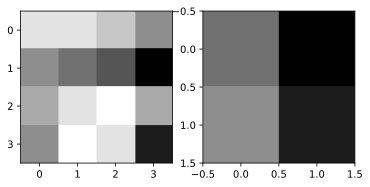

In [5]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)


plt.subplot(1, 2, 1)
plt.imshow(X.numpy()[0, :, :, 0], cmap='gray_r', vmin=0)

plt.subplot(1, 2, 2)
plt.imshow(pool(X).numpy().reshape(2, 2), cmap='gray_r', vmin=0)
print(pool(X).numpy().reshape(2, 2))

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 
In practice, there are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in worse performance. Observe below that there is more loss in finer detail when using overlapping pooling (right). 

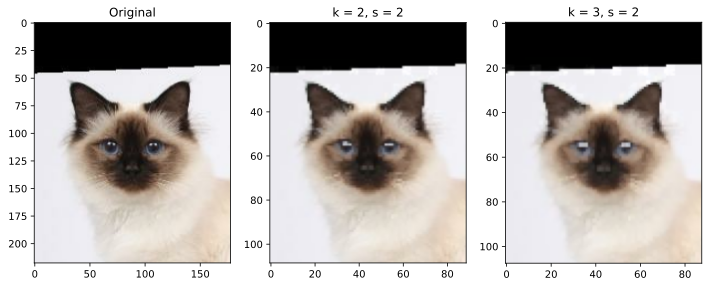

In [6]:
# Download cat image to `src/inefficient_networks/data/cat.jpg`
cat = config.DATASET_DIR / "cat.jpg"
image_raw = tf.io.read_file(str(cat))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=2, strides=2)(image)[0, :, :, :])
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=3, strides=2)(image)[0, :, :, :])
ax[2].set_title("k = 3, s = 2");

## Implementing a convnet

Using the Keras sequential API, let us implement the following convolutional network for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist`. Note that we use a width of 512 instead of 1024 from the figure below to reduce network capacity. We also add batch normalization.

```{margin}
⚠️ **Attribution:** The remaining sections follow the presentation in Chapter 14 of {cite}`mlbook2022`. [PyTorch code](https://github.com/rasbt/machine-learning-book/blob/main/ch14/) for this chapter is released under [MIT License](https://github.com/rasbt/machine-learning-book/blob/main/LICENSE.txt).
```

```{figure} ../../img/convnet.png
```

In [7]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.BatchNormalization(),
    kr.layers.MaxPooling2D(pool_size=2),
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.BatchNormalization(),
    kr.layers.MaxPooling2D(pool_size=2),
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [8]:
from tensorflow.keras.datasets import fashion_mnist

def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20


2022-04-28 00:37:05.004018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 00:37:05.258457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8303

2022-04-28 00:37:18.425248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 15s 18ms/step - loss: 0.4998 - accuracy: 0.8303 - val_loss: 0.3132 - val_accuracy: 0.8823
Epoch 2/20
782/782 [==============================] - 14s 18ms/step - loss: 0.3222 - accuracy: 0.8827 - val_loss: 0.2750 - val_accuracy: 0.8949
Epoch 3/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2787 - accuracy: 0.8998 - val_loss: 0.3023 - val_accuracy: 0.8890
Epoch 4/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2491 - accuracy: 0.9104 - val_loss: 0.2412 - val_accuracy: 0.9100
Epoch 5/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2219 - accuracy: 0.9175 - val_loss: 0.2448 - val_accuracy: 0.9098
Epoch 6/20
782/782 [==============================] - 14s 18ms/step - loss: 0.2063 - accuracy: 0.9236 - val_loss: 0.2370 - val_accuracy: 0.9145
Epoch 7/20
782/782 [==============================] - 15s 19ms/step - loss: 0.1873 - accuracy: 0.9314 - val_loss: 0.2178 - val_accuracy: 0.9218
Epo

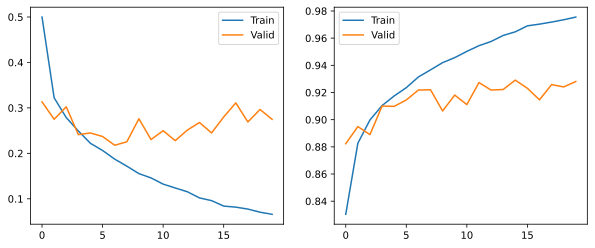

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(hist.history['loss'], label='Train')
ax[0].plot(hist.history['val_loss'], label='Valid')
ax[0].legend();

ax[1].plot(hist.history['accuracy'], label='Train')
ax[1].plot(hist.history['val_accuracy'], label='Valid')
ax[1].legend();

In [10]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 3s 9ms/step - loss: 0.3326 - accuracy: 0.9194
Test accuracy: 0.9194000363349915


Let us look at the model predictions:

In [133]:
class_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

pred_table.head(3)

,pred,proba,true
0,9,1.0,9
1,2,1.0,2
2,1,1.0,1


Plotting test examples where the model has perfect confidence:

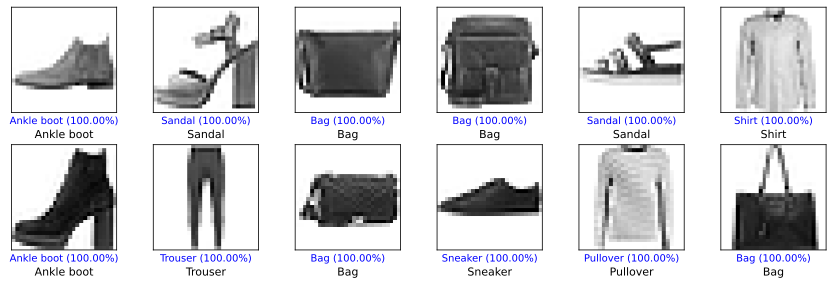

In [73]:
fig = plt.figure(figsize=(12, 4))
best_preds = pred_table.sort_values('proba', ascending=False)[:12]

for i in range(12):
    img_index = best_preds.index[i]
    image = X_test[img_index]
    row = best_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_label[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"{class_label[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

Plotting the 12 examples where model has lowest confidence:

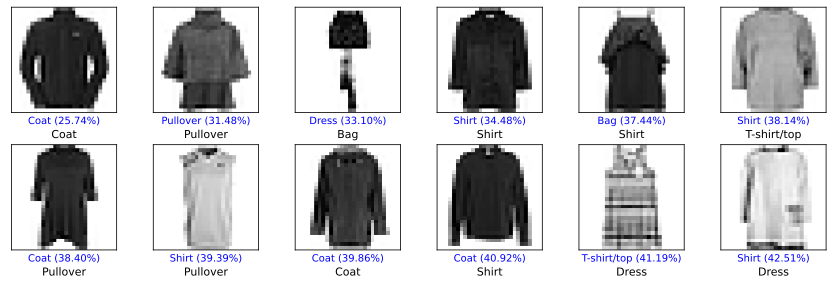

In [72]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_label[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"{class_label[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

## Data augmentation

In this section, we will create a convolutional network for classifying whether or not an image of a person is smiling or not. The dataset we will be using is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of celebrities’
faces. In addition, 40 binary facial attributes are available for each image, including whether a celebrity is smiling or not. 

To speed up training we will use only a small subset of 16,000 faces. However, this is a small dataset (even smaller than FashionMNIST). To increase the size of the dataset, and improve generalization, we will use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset resulting in a model that is robust to changes that should not affect semantics such as rotation and translation.

In [2]:
# Dowload data
utils.download_kaggle_dataset('jessicali9530/celeba-dataset')
image_dir_path = config.DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])

Dataset already exists in /Users/particle1331/code/inefficient-networks/src/inefficient_networks/data/celeba-dataset
Skipping download.


Plotting example images with their labels:

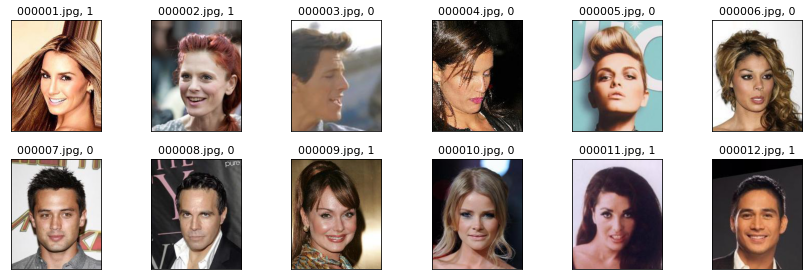

In [4]:
import pandas as pd

# Get id -> target dictionary
dataset_path = config.DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transformations

For the sake of demonstration, we apply various transformations on a single image. These are cropping to a bounding box, flipping horizontally, adjusting the contrast, adjusting the brightness, and  center-cropping and resizing the resulting image back to its original size, 218 x 178. All of these are available in the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) library.

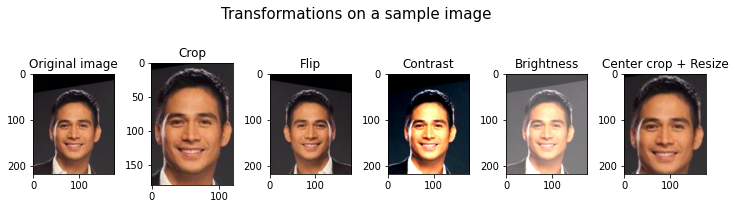

In [16]:
# Get sample image
image = plt.imread(face_file_list[11])

# Apply augmentations to sample image
cropped = tf.image.crop_to_bounding_box(image, 25, 30, 180, 120)
flipped = tf.image.flip_left_right(image)
contrast_adjusted = tf.image.adjust_contrast(image, 2.)
brightness_adjusted = tf.image.adjust_brightness(image, delta=0.3)
center_cropped = tf.image.central_crop(image, central_fraction=0.7)
resized_center_cropped = tf.image.resize(center_cropped, size=[218, 178]) / 255.

# Visualize
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

ax[0].set_title("Original image")
ax[1].set_title("Crop")
ax[2].set_title("Flip")
ax[3].set_title("Contrast")
ax[4].set_title("Brightness")
ax[5].set_title("Center crop + Resize")

ax[0].imshow(image)
ax[1].imshow(cropped)
ax[2].imshow(flipped)
ax[3].imshow(contrast_adjusted)
ax[4].imshow(brightness_adjusted)
ax[5].imshow(resized_center_cropped)

fig.suptitle("Transformations on a sample image", fontsize=15)
fig.tight_layout()

Observe that the transformations above are all deterministic. For data augmentation during training, we incorporate some randomness into these transformations. For example, the parameters for contrast and brightness change can be drawn from some uniform distribution. For our training dataset we apply a sequence of transformation: first we perform random cropping so the model can focus more on the face, this is followed by a random horizontal flip, and a final resize to 64 x 64. For test data, we remove the stochasticity as we want to avoid unnecessary information loss.

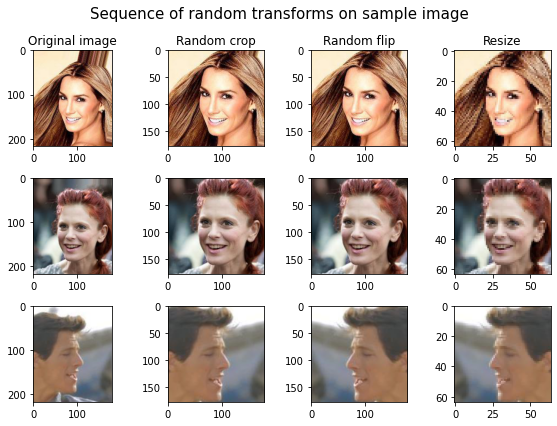

In [139]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Random crop")
ax[0, 2].set_title("Random flip")
ax[0, 3].set_title("Resize")

for i, file_name in enumerate(face_file_list[:3]):
    image = plt.imread(file_name)
    ax[i, 0].imshow(image)
    image = tf.image.random_crop(image, size=(178, 178, 3))
    ax[i, 1].imshow(image)
    image = tf.image.random_flip_left_right(image)
    ax[i, 2].imshow(image)
    image = tf.image.resize(image, size=[64, 64]) / 255.
    ax[i, 3].imshow(image)
    
fig.suptitle("Sequence of random transforms on sample image", fontsize=15)
fig.tight_layout()

The 64x64 images in the last column are those that will make up the training data. Next, we formalize this process by defining a tranformation pipeline and simulate how three sample images are presented to the model across multiple epochs. Note that we prefer using exactly one transformed version of an image per epoch so that the model is not biased, in contrast to the alternative of using multiple transformations of a single image in one epoch. We also want to avoid cropping too aggressively, otherwise we might crop the mouth out of the image which is highly predictive of a smile.

### Creating the augmented dataset

We now load the JPEG files into a TensorFlow dataset and apply the transformation to get a `MapDataset`. The whole process was introduced in a [previous notebook](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/01-tensorflow-nn.html#dataset-from-local-files). 

In [206]:
from functools import partial

@tf.function
def transform(image, size=(64, 64), training=True):
    """Full image transformation pipeline."""
    
    if training:
        image = tf.image.random_crop(image, size=(178, 178, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0, 
            target_height=178, target_width=178
        ) # (218 - 178)/2 = 20, (178 - 178)/2 = 0

    image = tf.image.resize(image, size=size) / 255.
    return image
    

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image


def image_id(file_path):
    return file_path.split('/')[-1] 


def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds


# Create train, valid, and test data loaders outside of train loop
train_ds = create_image_dataset(face_file_list[:16000])
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (transform(x), y))

valid_ds = create_image_dataset(face_file_list[16000:17000])
valid_ds = valid_ds.map(lambda x, y: (transform(x, training=False), y))

test_ds = create_image_dataset(face_file_list[17000:18000])
test_ds = test_ds.map(lambda x, y: (transform(x, training=False), y))

Each dataset above is a `MapDataset` so that the mapping is applied lazily each time the dataset is iterated over. This is good since we want a different randomization for each epoch. Note that the ordering between `shuffle` and `map` seems to be significant as well as setting `reshuffle_each_iteration` to `True`. This is done so that `shuffle` [maintains state across iterations](https://github.com/tensorflow/tensorflow/issues/35682#issuecomment-578334425) and we get different augmentations for each epoch. Batch size for the data loaders will have to be set up later.

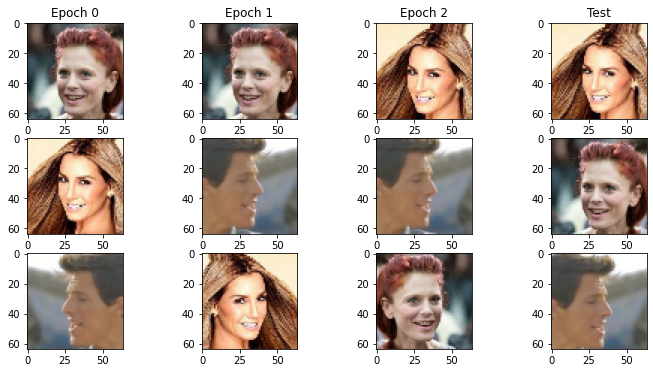

In [210]:
# In this demo, we likewise create loaders outside of train loops
train_demo = create_image_dataset(face_file_list[:3])
train_demo = train_demo.shuffle(1000)                           # ordering important!
train_demo = train_demo.map(lambda x, y: (transform(x), y))     # shuffle -> map
train_demo = train_demo.batch(1)

fig, ax = plt.subplots(3, 4, figsize=(12, 6))

# Training
for epoch in range(3):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        ax[b, epoch].imshow(batch[0][0, :, :, :])

# Inference: use same images for comparison
test_demo = create_image_dataset(face_file_list[:3])
test_demo = test_demo.map(lambda x, y: (transform(x, training=False), y))
test_demo = test_demo.batch(1)

ax[0, 3].set_title(f"Test")
for b, batch in enumerate(test_demo):
    ax[b, 3].imshow(batch[0][0, :, :, :])

### Model architecture

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification.